# UE IA pour la robotique: Travaux pratiques Algorithmes Evolutionnistes


* Étudiant1: Nom: Bounadja Prénom: Bilal
* Étudiant2: Nom: Touami Prénom: Abdelrahmaine


Pour faciliter le suivi, merci à chaque membre du binome de soumettre de son côté.


## Introduction

Dans ce TME, vous allez prendre en main différents algorithmes évolutionnistes multi-objectifs et regarder comment ils se comportent. Pour cela, différentes fonctions vous sont fournies afin de tracer les individus générés à chaque génération ou de comparer les résultats entre eux. Vous testerez également Gym (dans sa nouvelle version fournie par le package gymnasium), un environnement utilisé en apprentissage par renforcement pour normaliser les expériences d'apprentissage sur des robots (virtuels).

Vous complèterez ce notebook et le soumettrez sur Moodle. 

**Vous prendrez soin d'assurer la lisibilité de votre notebook**: limitez l'affichage au nécessaire et n'oubliez pas d'enlever les affichages que vous utiliserez peut-être pendant la phase de développement et de débogage. La lisibilité de votre notebook influera sur l'évaluation de votre travail. 

Vous aurez besoin de la bibliothèque DEAP (https://deap.readthedocs.io/en/master/) et de Gymnasium (https://github.com/Farama-Foundation/Gymnasium). Ces bibliothèques s'installent facilement avec la commande `pip`, comme indiqué ci-dessous:

In [1]:
#!pip install deap
#!pip install gymnasium

Remarque: vous pouvez également utiliser la bibliothèque scoop, qui permet de paralléliser l'exécution de vos expériences et donc de rendre l'exécution bien plus rapide. Scoop ne peut cependant pas s'utiliser directement dans un notebook jupyter. Si vous souhaitez l'utiliser, il faut mettre votre code dans un fichier python et l'exécuter avec un python -m scoop mon_code.py. Il vous est conseillé de commencer avec le notebook. Vous pourrez utiliser de petites tailles de population et peu de générations. Si vous finissez en avance, vous pourrez utiliser scoop pour lancer des expériences avec des tailles de populations plus variées et un plus grand nombre de générations.

In [6]:
# Note: l'import d'un fichier ne se fait qu'une seule fois. Si vous modifiez ce fichier, 
# il vous faut redémarrer votre kernel si vous voulez prendre en compte les modifications.
# vous pouvez éviter cela de la façon suivante: 
import importlib # une seule fois
import random

#import mon_module_python # le module doit avoir été importé une première fois
#importlib.reload(mon_module_python) # cette ligne permet de charger la dernière version

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from deap import base, creator, benchmarks, algorithms, tools


# ne pas oublier d'initialiser la graine aléatoire 
random.seed()
# pour que les figures apparaissent directement dans le notebook
%matplotlib inline 

## ANNEXE

In [7]:

import os

def sigmoid(x):
    return 1./(1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)


def gen_simplemlp(n_in, n_out, n_hidden_layers=2, n_neurons_per_hidden=5):
    n_neurons = [n_neurons_per_hidden]*n_hidden_layers if np.isscalar(n_neurons_per_hidden) else n_neurons_per_hidden
    i = Input(shape=(n_in,))
    x = i
    for n in n_neurons:
        x = Dense(n, activation='sigmoid')(x)
    o = Dense(n_out, activation='tanh')(x)
    m = Model(inputs=i, outputs=o)
    return m


class SimpleNeuralControllerNumpy():
    def __init__(self, n_in, n_out, n_hidden_layers=2, n_neurons_per_hidden=5, params=None):
        self.dim_in = n_in
        self.dim_out = n_out
        # if params is provided, we look for the number of hidden layers and neuron per layer into that parameter (a dicttionary)
        if (not params==None):
            if ("n_hidden_layers" in params.keys()):
                n_hidden_layers=params["n_hidden_layers"]
            if ("n_neurons_per_hidden" in params.keys()):
                n_neurons_per_hidden=params["n_neurons_per_hidden"]
        self.n_per_hidden = n_neurons_per_hidden
        self.n_hidden_layers = n_hidden_layers
        self.weights = None
        self.n_weights = None
        self.init_random_params()
        self.out = np.zeros(n_out)
        #print("Creating a simple mlp with %d inputs, %d outputs, %d hidden layers and %d neurons per layer"%(n_in, n_out,n_hidden_layers, n_neurons_per_hidden))


    def init_random_params(self):
        if(self.n_hidden_layers > 0):
            self.weights = [np.random.random((self.dim_in,self.n_per_hidden))] # In -> first hidden
            self.bias = [np.random.random(self.n_per_hidden)] # In -> first hidden
            for i in range(self.n_hidden_layers-1): # Hidden -> hidden
                self.weights.append(np.random.random((self.n_per_hidden,self.n_per_hidden)))
                self.bias.append(np.random.random(self.n_per_hidden))
            self.weights.append(np.random.random((self.n_per_hidden,self.dim_out))) # -> last hidden -> out
            self.bias.append(np.random.random(self.dim_out))
        else:
            self.weights = [np.random.random((self.dim_in,self.dim_out))] # Single-layer perceptron
            self.bias = [np.random.random(self.dim_out)]
        self.n_weights = np.sum([np.product(w.shape) for w in self.weights]) + np.sum([np.product(b.shape) for b in self.bias])

    def get_parameters(self):
        """
        Returns all network parameters as a single array
        """
        flat_weights = np.hstack([arr.flatten() for arr in (self.weights+self.bias)])
        return flat_weights

    def set_parameters(self, flat_parameters):
        """
        Set all network parameters from a single array
        """
        i = 0 # index
        to_set = []
        self.weights = list()
        self.bias = list()
        if(self.n_hidden_layers > 0):
            # In -> first hidden
            w0 = np.array(flat_parameters[i:(i+self.dim_in*self.n_per_hidden)])
            self.weights.append(w0.reshape(self.dim_in,self.n_per_hidden))
            i += self.dim_in*self.n_per_hidden
            for l in range(self.n_hidden_layers-1): # Hidden -> hidden
                w = np.array(flat_parameters[i:(i+self.n_per_hidden*self.n_per_hidden)])
                self.weights.append(w.reshape((self.n_per_hidden,self.n_per_hidden)))
                i += self.n_per_hidden*self.n_per_hidden
            # -> last hidden -> out
            wN = np.array(flat_parameters[i:(i+self.n_per_hidden*self.dim_out)])
            self.weights.append(wN.reshape((self.n_per_hidden,self.dim_out)))
            i += self.n_per_hidden*self.dim_out
            # Samefor bias now
            # In -> first hidden
            b0 = np.array(flat_parameters[i:(i+self.n_per_hidden)])
            self.bias.append(b0)
            i += self.n_per_hidden
            for l in range(self.n_hidden_layers-1): # Hidden -> hidden
                b = np.array(flat_parameters[i:(i+self.n_per_hidden)])
                self.bias.append(b)
                i += self.n_per_hidden
            # -> last hidden -> out
            bN = np.array(flat_parameters[i:(i+self.dim_out)])
            self.bias.append(bN)
            i += self.dim_out
        else:
            n_w = self.dim_in*self.dim_out
            w = np.array(flat_parameters[:n_w])
            self.weights = [w.reshape((self.dim_in,self.dim_out))]
            self.bias = [np.array(flat_parameters[n_w:])]
        self.n_weights = np.sum([np.product(w.shape) for w in self.weights]) + np.sum([np.product(b.shape) for b in self.bias])

    def predict(self,x):
        """
        Propagage
        """
        if(self.n_hidden_layers > 0):
            #Input
            a = np.matmul(x,self.weights[0]) + self.bias[0]
            y = sigmoid(a)
            # hidden -> hidden
            for i in range(1,self.n_hidden_layers-1):
                a = np.matmul(y, self.weights[i]) + self.bias[i]
                y = sigmoid(a)
            # Out
            a = np.matmul(y, self.weights[-1]) + self.bias[-1]
            out = tanh(a)
            return out
        else: # Simple monolayer perceptron
            return tanh(np.matmul(x,self.weights[0]) + self.bias[0])

    def __call__(self,x):
        """Calling the controller calls predict"""
        return self.predict(x)


## 1. Prise en main de DEAP

Dans la suite du TME, vous serez invités à utiliser DEAP, qui est une bibliothèque python open source, cf https://deap.readthedocs.io/en/master/index.html.

DEAP est une bibliothèque de prototypage rapide d'algorithmes évolutionnistes. Elle permet de travailler à plusieurs niveaux, depuis l'implémentation complète de l'algorithme à partir de briques de base jusqu'à l'utilisation boite noire d'un algorithme entièrement implémenté et en passant par des approches intermédiaires, dans lesquelles des modules sont réutilisés, par exemple pour la sélection, les mutations ou les croisements.  


Écrivez un algorithme évolutionniste de type élitiste qui génèrera lambda individus de type vecteurs de paramètres et choisira les mu meilleurs parmi les parents et les enfants. 

Vous utiliserez un croisement de type SBX (Simulated Binary Crossover) et une mutation de type polynomiale bornée (eta=15.0).

Les paramètres seront entre -5 et 5 (vous pourrez utiliser random.uniform pour l'initialisation).

Vous utiliserez les fonctions de la toolbox DEAP pour faciliter votre implémentation et vous pourrez vous inspirer des exemples fournis. 

Vous testerez votre algorithme sur la fonction de Ackley. Elle est disponible dans DEAP et peut être appelées dans n'importe quelle dimension. Vous pourrez faire vos tests avec la dimension 10, par exemple. 


Les algorithmes évolutionnistes ont une part stochastique et ne donnent donc pas toujours le même résultat. Vous tracerez donc l'évolution de la fitness moyenne pour 10 runs indépendants. Plutôt que de tracer les 10 courbes, vous tracerez la médiane des moyennes et un intervalle représentant le 1er et le 3eme quartile. Vous procéderez pour cela de la façon suivante:


    plt.plot(gen,moyennes, label="Median of the average fitnesses")
    plt.fill_between(gen, fit_25, fit_75, alpha=0.25, linewidth=0)

gen étant une liste de générations, moyenne la liste des médianes de moyennes et fit_25 et fit_75 les 1er et 3eme quartiles pour ces générations. Vous pourrez déterminer fit_25 et fit_75 avec la fonction quantile de numpy: quantile(points, 0.25) et quantile(points, 0.75), avec points une liste qui contient les fitness des différents runs à une génération donnée (il faut donc faire une boucle et appeler ces fonctions pour chaque génération).


Tracez les courbes pour des populations de taille croissante: [5, 10, 100, 200]. Que constatez-vous ?


In [9]:
# parameters values
MIN_VALUE = -5
MAX_VALUE = 5
CXPB = 0.8 # Taux de croisement
MUTPB = 0.2 # Taux de mutation


In [10]:
# complétez le code dans cette cellule 

def ea_simple(n, nbgen, evaluate, IND_SIZE, weights=(-1.0,)):
    """Algorithme evolutionniste elitiste

    Algorithme evolutionniste elitiste.
    :param n: taille de la population
    :param nbgen: nombre de generation
    :param evaluate: la fonction d'évaluation
    :param IND_SIZE: la taille d'un individu
    :param weights: les poids à utiliser pour la fitness (ici ce sera (-1.0,) pour une fonction à minimiser et (1.0,) pour une fonction à maximiser)
    """

    if (hasattr(creator, "FitnessMin")):
        del creator.FitnessMin
    if (hasattr(creator, "Individual")):
        del creator.Individual

    creator.create("FitnessMin", base.Fitness, weights=weights)
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    ## à compléter pour sélectionner les opérateurs de mutation, croisement, sélection avec des toolbox.register(...)
    toolbox.register("attribute",random.uniform,a=MIN_VALUE,b=MAX_VALUE)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=IND_SIZE)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxSimulatedBinary,eta=15.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, eta=15.0,low=MIN_VALUE,up=MAX_VALUE,indpb=1/IND_SIZE)
    toolbox.register("select", tools.selBest,k=n)
    toolbox.register("evaluate", evaluate)


    # Les statistiques permettant de récupérer les résultats
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # La structure qui permet de stocker les statistiques
    logbook = tools.Logbook()

    # La structure permettant de récupérer le meilleur individu
    hof = tools.HallOfFame(1)

    ## à compléter pour initialiser l'algorithme, n'oubliez pas de mettre à jour les statistiques, le logbook et le hall-of-fame.
    pop = toolbox.population(n=n)
    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for g in range(1, nbgen):
        # Clone the initial population
        offspring = list(map(toolbox.clone, pop))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The next population is selected
        pop[:] = toolbox.select(pop + offspring)

        # Pour voir l'avancement
        """if (g%10==0):
            print("+",end="", flush=True)
        else:
            print(".",end="", flush=True)"""

        ## à compléter en n'oubliant pas de mettre à jour les statistiques, le logbook et le hall-of-fame
        logbook.record(gen=g,**stats.compile(pop))
        hof.update(pop)
        
    return pop, hof, logbook



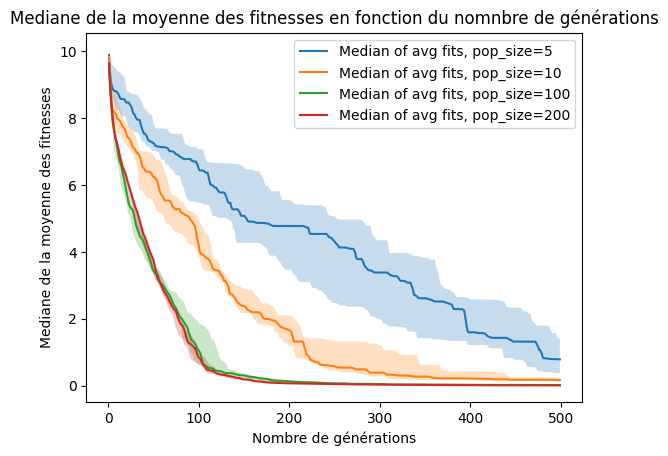

In [13]:
# Insérez ici le code permettant d'appeler votre algorithme et de tracer les courbes de résultats

pop_size = [5, 10, 100, 200]

nbgen = 500 # à réduire dans un premier si trop lent
ind_size = 10
nbrun = 10
## à compléter, n'oubliez pas de mettre quelques commentaires sur les résultats dans la cellule suivante
for p in pop_size:
    moyenne = []
    for _ in range(nbrun):
        pop, hof, logbook = ea_simple(p,nbgen,benchmarks.ackley,ind_size)
        gen, avg = logbook.select("gen","avg") 
        moyenne.append(avg)
    moyennes = np.median(moyenne,axis=0)
    fit_25 = np.quantile(moyenne, 0.25,axis=0)
    fit_75 = np.quantile(moyenne, 0.75,axis=0)

    plt.plot(gen,moyennes, label=f"Median of avg fits, pop_size={p}")
    plt.fill_between(gen,fit_25, fit_75, alpha=0.25, linewidth=0)
plt.xlabel('Nombre de générations')
plt.ylabel("Mediane de la moyenne des fitnesses")
plt.title('Mediane de la moyenne des fitnesses en fonction du nomnbre de générations')
plt.legend()
plt.show()

Plus la taille de la population est importante plus les valeurs des fitness convergent rapidement, la dispersion est elle aussi affectée, en effet plus la taille de la population est faible plus il y a de dispersion autour de la mediane des valeurs moyennes. On en déduis donc qu'avec cette sélection, la taille de la population de base a une incidence importante sur les valeurs des fitness, en effet plus il y a d'individus plus il y a de chances d'avoir de bons individus.

## 2. Apprentissage de politiques avec gym

L'objectif de cette question est de faire un premier apprentissage de politiques. Vous utiliserez pour cela un problème très simple: le pendule inversé. Il s'agit de contrôler un pendule fixé sur un chariot et capable de tourner. Le chariot peut se déplacer horizontalement avec deux actions (contrôle "bang-bang"). Les mouvements horizontaux du pendule font osciller le pendule et l'objectif est de le maintenir à la verticale. Vous utiliserez une politique de type réseau de neurones. Le code correspondant est fourni en annexe (il faut donc l'exécuter pour accéder aux fonctions correspondantes).

OpenAI-gym (maintenant Gymnasium) est un framework permettant d'implémenter des expériences d'apprentissage par renforcement. Il propose une interface simple et unifiée et inclut de nombreux environnements utilisés pour tester des algorithmes d'apprentissage par renforcement. Vous utiliserez cet environnement et son module CartPole-v1 pour apprendre à contrôler le pendule (voir https://gymnasium.farama.org/environments/classic_control/cart_pole/). 

Complétez le code ci-dessous. Vous tracerez dans le notebook l'évolution des fitness comme dans la question précédente. Les calculs étant plus longs, faites en fonction de vos capacités de calcul et, le cas échéant, indiquez en commentaire ce que vous vous attendriez à observer avec une puissance de calcul supérieure. Vous pourrez ne faire le tracé que pour une taille de population.

In [15]:
# à compléter pour appeler votre algorithme évolutionniste sur les différentes tailles de population et tracer l'évolution de la fitness moyenne
# commenter les résultats en quelques mots.

import gymnasium as gym

nn=SimpleNeuralControllerNumpy(4,1,2,5)
IND_SIZE=len(nn.get_parameters())
nn.init_random_params()
random_genotype = nn.get_parameters()
render = False
env = gym.make('CartPole-v1',render_mode="human") if render else gym.make('CartPole-v1')

"""
Commentaires:

le nombre de weights correspond au nombre de connexions
le nombre de bias correspond au nombre de neuronnes
genotype est un array contentant les poids et les biais

"""
def eval_nn(genotype, nbstep=500):
    nn.set_parameters(genotype)
    nbeval=5
    # nbstep est le nombre de pas de temps. Plus il est grand, plus votre pendule sera stable, mais par contre, plus vos calculs seront longs. Vous pouvez donc ajuster cette
    # valeur pour accélérer ou ralentir vos calculs. Utilisez la valeur par défaut pour indiquer ce qui doit se passer pendant l'apprentissage, vous pourrez indiquer une
    # valeur plus importante pour visualiser le comportement du résultat obtenu.

    # utilisez render pour activer ou inhiber l'affichage (si hors notebook).

    ## à compléter en s'inspirant de la documentation de l'environnement CartPole

    rewards = []
    for _ in range(nbeval): 
        total_reward=0
        observation, info = env.reset()
        for _ in range(nbstep):
            action = 0 if nn.predict(observation) > 0 else 1
            observation, reward, terminated, truncated, info = env.step(action)
            total_reward+=reward
            if terminated or truncated:
                break
        rewards.append(total_reward)
    return np.mean(rewards),



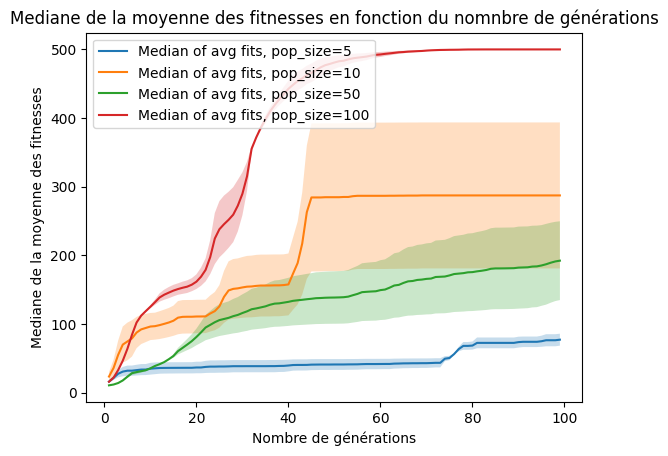

In [17]:
pop_size = [5,10,50,100]
nbgen = 100
nbrun = 2

## à compléter... Vous n'oublierez pas de mettre quelques commentaires sur les résultats obtenus dans la cellule suivante.
for p in pop_size:
    moyenne = []
    for _ in range(nbrun):
        pop, hof, logbook = ea_simple(p,nbgen,eval_nn,IND_SIZE,weights= (1,))
        gen, avg = logbook.select("gen","avg") 
        moyenne.append(avg)
    moyennes = np.median(moyenne,axis=0)
    fit_25 = np.quantile(moyenne, 0.25,axis=0)
    fit_75 = np.quantile(moyenne, 0.75,axis=0)

    plt.plot(gen,moyennes, label=f"Median of avg fits, pop_size={p}")
    plt.fill_between(gen,fit_25, fit_75, alpha=0.25, linewidth=0)
plt.xlabel('Nombre de générations')
plt.ylabel("Mediane de la moyenne des fitnesses")
plt.title('Mediane de la moyenne des fitnesses en fonction du nomnbre de générations')
plt.legend()
plt.show()


In [19]:
# à compléter pour appeler votre algorithme évolutionniste sur les différentes tailles de population et tracer l'évolution de la fitness moyenne
# commenter les résultats en quelques mots.

env = gym.make('CartPole-v1',render_mode="human") 
eval_nn(hof[0], nbstep=500)


(485.6,)

In [20]:
env.close()

Les plus petites populations convergent rapidement vers une solution mais la maximisation des solutions est moindre, de plus il y a une forte dispersion des valeurs autour de la médiane des moyennes.

**Remarque**: L'évaluation du pendule commence à une position aléatoire. Affichez plusieurs fois de suite la fitness obtenue en visualisant un même individu. Vous devriez observez que la fitness obtenue n'est pas toujours la même. C'est une illustration du problème de la généralisation: pendant l'apprentissage, une politique n'a été testée que dans une condition particulière. Si vous changer un peu les conditions, vous n'avez pas de garantie sur ce qu'il va se passer... Pour limiter ce problème, une stratégie simple consiste à calculer la fitness non pas sur une seule évaluation, mais sur plusieurs. Cela devrait réduire la variabilité observée. Si la puissance de calcul dont vous disposez le permet, vous pouvez modifier ainsi votre fontion d'évaluation.

## 3. Implémentation de NSGA-II

Implémentez maintenant NSGA-II en vous appuyant sur les fonctions fournies dans DEAP. Vous testerez NSGA-II sur un benchmark multi-objectif fourni dans DEAP, par exemple, la fonction de Fonseca et Fleming.

Il n'est pas immédiat de caractériser les performances d'un algorithme multi-objectif avec un indicateur à une seule dimension. Vous allez utiliser l'hypervolume qui correspond au volume délimité par le front de pareto et un point de référence donné. 

Comme précédemment, tracez l'évolution de l'hypervolume (mediane et 1er et 3eme quartiles) pour des populations de taille [5, 10, 100, 200]. 

Que remarquez-vous ?

Dans le cas de la fonction de Fonseca, vous pourrez utiliser (1,1) comme point de référence.

In [21]:
print("Exemple d'utilisation du code de calcul de l'hypervolume. L'hypothèse est celle d'une minimisation.")
print("Il faut donner un point de référence correspondant, par exemple, aux valeurs maximales pour les objectifs.")
from deap.tools._hypervolume import hv
print("Hypervolume: %f"%(hv.hypervolume([np.array([1,0]), np.array([1,1]), np.array([0,1])], np.array([2,2]))))


Exemple d'utilisation du code de calcul de l'hypervolume. L'hypothèse est celle d'une minimisation.
Il faut donner un point de référence correspondant, par exemple, aux valeurs maximales pour les objectifs.
Hypervolume: 3.000000


In [22]:
BOUND_LOW, BOUND_UP = -5, 5
CXPB = 0.9
MUTPB = 0.2

def my_nsga2(n, nbgen, evaluate, ref_point=np.array([1,1]), IND_SIZE=5, weights=(-1.0, -1.0)):
    """NSGA-2

    NSGA-2
    :param n: taille de la population
    :param nbgen: nombre de generation
    :param evaluate: la fonction d'évaluation
    :param ref_point: le point de référence pour le calcul de l'hypervolume
    :param IND_SIZE: la taille d'un individu
    :param weights: les poids à utiliser pour la fitness (ici ce sera (-1.0,) pour une fonction à minimiser et (1.0,) pour une fonction à maximiser)
    """

    """
    NSGA-2 Main Loop:

    1) Create offspring and a combined population
    2) Rank and sort offspring due to performance* on defined target indicators
    3) Take best members to create new population including a good spread in solutions

    * the performance here is given by the hypervolume
    """
    if (hasattr(creator, "MaFitness")):
        del creator.MaFitness
    if (hasattr(creator, "Individual")):
        del creator.Individual
        
    creator.create("MaFitness", base.Fitness, weights=weights)
    creator.create("Individual", list, fitness=creator.MaFitness)


    toolbox = base.Toolbox()
    paretofront = tools.ParetoFront()

    ## à compléter (initialisation, évaluation et mise à jour du front de pareto)
    toolbox.register("attribute", random.uniform,a=BOUND_LOW,b=BOUND_UP)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=IND_SIZE)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxSimulatedBinary,eta=15.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, eta=15.0,low=BOUND_LOW,up=BOUND_UP, indpb=MUTPB)
    toolbox.register("select", tools.selNSGA2,k=n, nd = 'standard' )
    toolbox.register("evaluate", evaluate)


    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)

    # La structure qui permet de stocker les statistiques
    logbook = tools.Logbook()
    logbook.header = "gen", "avg", "hv"

    # La structure permettant de récupérer le meilleur individu
    hof = tools.HallOfFame(1)

    # Pour récupérer l'hypervolume, nous nous contenterons de mettre les différentes aleur dans un vecteur s_hv qui sera renvoyé par la fonction.
    pop = toolbox.population(n=n)
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
        
    paretofront.update(pop)
    pointset=[np.array(ind.fitness.getValues()) for ind in paretofront]
    s_hv=[hv.hypervolume(pointset, ref_point)]

    # Begin the generational process

    for gen in range(1, nbgen):

        ## à completer (population "enfants", évaluation, sélection et mise à jour du front de pareto)
        offspring = list(map(toolbox.clone, pop))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = toolbox.select(pop + offspring)

        paretofront.update(pop)
        pointset=[np.array(ind.fitness.getValues()) for ind in paretofront]
        s_hv.append(hv.hypervolume(pointset, ref_point))
        logbook.record(gen=gen,**stats.compile(pop),hv=s_hv[-1])
        hof.update(pop)
        
    return pop, paretofront, logbook


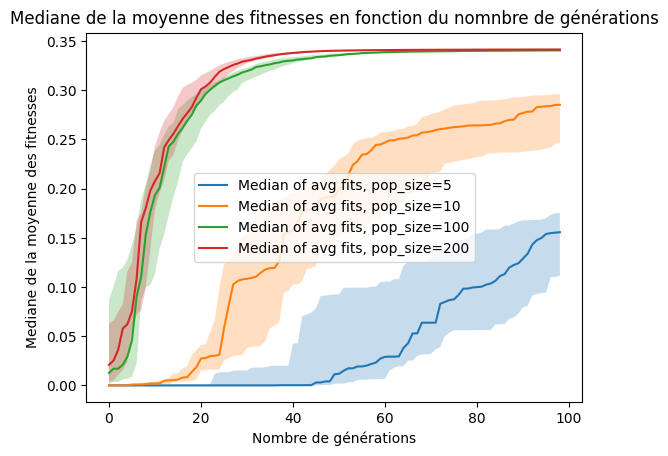

In [28]:
random.seed()
pop_size = [5, 10, 100, 200]
nbgenn = 100 # à réduire dans un premier temps si trop lent

## à compléter. Ne pas oublier de mettre un commentaire sur les résultats dans la cellule suivante.
for p in pop_size:
    moyenne = []
    for _ in range(10):
        pop, paretofront, logbook = my_nsga2(p,nbgenn,benchmarks.fonseca)
        s_hv = logbook.select("hv")
        moyenne.append(s_hv)
    moyennes = np.median(moyenne,axis=0)
    fit_25 = np.quantile(moyenne, 0.25,axis=0)
    fit_75 = np.quantile(moyenne, 0.75,axis=0)

    plt.plot(moyennes, label=f"Median of avg fits, pop_size={p}")
    plt.fill_between(range(len(fit_25)),fit_25, fit_75, alpha=0.25, linewidth=0)
plt.xlabel('Nombre de générations')
plt.ylabel("Mediane de la moyenne des fitnesses")
plt.title('Mediane de la moyenne des fitnesses en fonction du nomnbre de générations')
plt.legend()
plt.show()

Avec NSGA-2 on a une convergence plus rapide que pour l'algorithme élitiste, ici on observe le meme phenomène que précèdemment la taille des populations a une incidence sur la convergence des fitness, en effet plus la population est grande plus la convergence est rapide, on remarque par ailleurs qu'a partir d'une certaine valeur seuil augmenter la population n'a plus vraiment d'incidence, les courbes vertes et rouges se chevauchent pratiquement. On peut également constater que la dispersion diminue avec l'augmentation de la taille de la population.

## 4. Apprentissage direct dans l'espace des politiques, version multi-objectif

Le pendule inversé est en fait un problème multi-objectif dans lequel le pendule doit être maintenu à la verticale, le chariot étant centré dans une zone donnée. 

Compléter le code ci-dessous pour minimiser l'erreur en x et en theta avec NSGA-2. Vous pourrez tracer l'évolution de l'hypervolume ou modifier le code de NSGA2 pour tracer l'évolution de l'erreur en x et de l'erreur en theta. 



In [29]:
# à compléter pour appeler votre algorithme évolutionniste sur les différentes tailles de population et tracer l'évolution de la fitness moyenne
# commenter les résultats en quelques mots.


def eval_nn2(genotype, render = False, nbstep=500):
    """
    An observation gives us the following information:

    idx | info
    ------------------
    0	| Cart Position
    1	| Cart Velocity
    2	| Pole Angle
    3	| Pole Velocity At Tip

    """
    total_pos = 0 # l'erreur en x est dans observation[0]
    total_angle = 0 #  l'erreur en theta est dans obervation[2]
    nn=SimpleNeuralControllerNumpy(4,1,2,5)
    nn.set_parameters(genotype)

    obs, info = env.reset(seed=42)

    ## à compléter ...
    
    total_reward=0
    observation, info = env.reset()
    for i in range(nbstep):
        action = 0 if nn.predict(observation) > 0 else 1
        observation, reward, terminated, truncated, info = env.step(action)
        total_pos+=np.abs(observation[0])
        total_angle+=np.abs(observation[2])
        if terminated or truncated:
            #print(truncated)
            n=nbstep-i
            break

    # ATTENTION: vous êtes dans le cas d'une fitness à minimiser. Interrompre l'évaluation
    # le plus rapidement possible est donc une stratégie que l'algorithme évolutionniste
    # peut utiliser pour minimiser la fitness. Dans le cas ou le pendule tombe avant la fin,
    # il faut donc ajouter à la fitness une valeur qui guidera l'apprentissage vers les bons
    # comportements. Vous pouvez par exemple ajouter n fois une pénalité, n étant le nombre de pas de temps restant. Cela poussera l'algorithme à minimiser la pénalité et donc à éviter la chute. La pénalité peut être l'erreur au moment de la chute ou l'erreur maximale.
    """print(n)
    print(total_pos)
    print(total_angle)"""
    return (total_pos+n, total_angle+n)

In [31]:
env = gym.make('CartPole-v1',render_mode="human") 


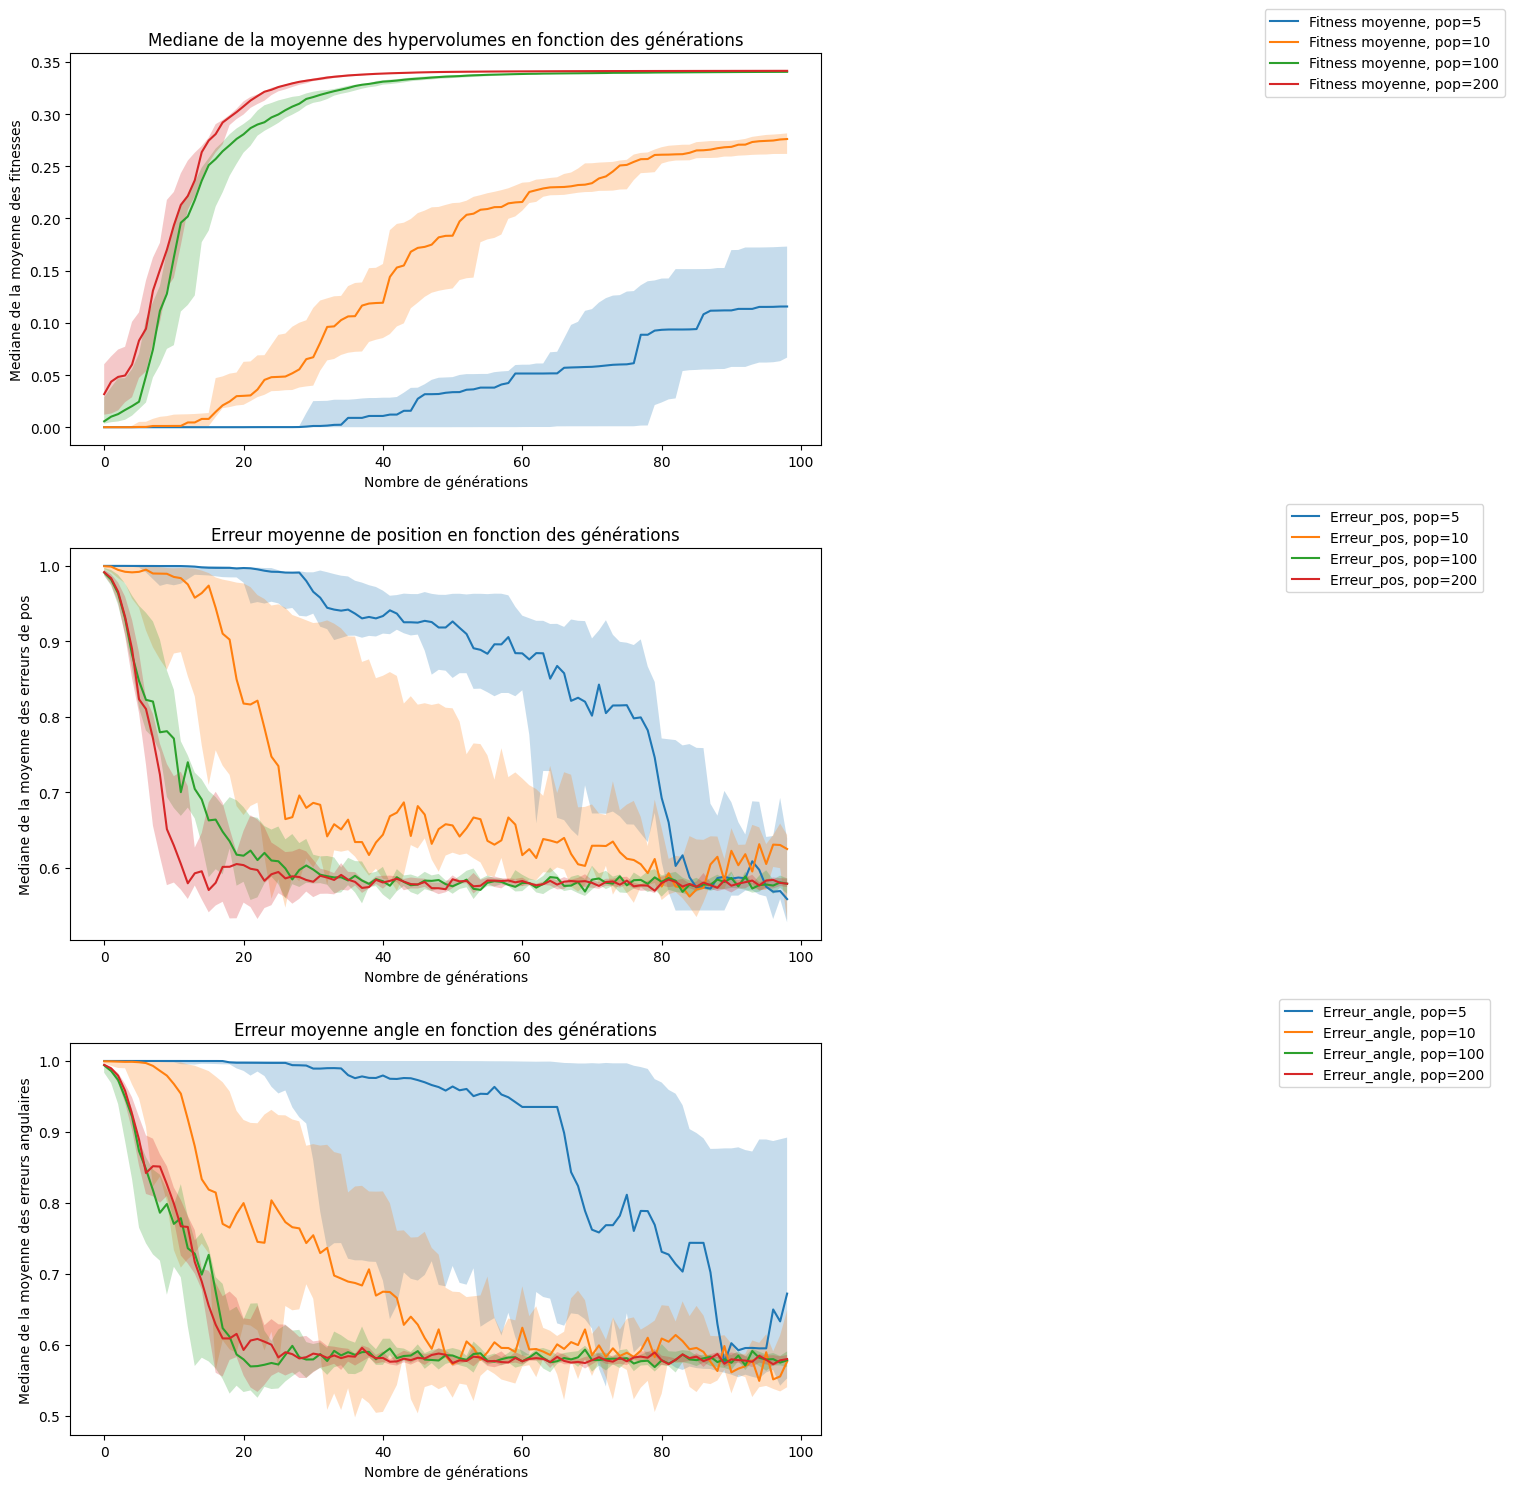

In [50]:
nn=SimpleNeuralControllerNumpy(4,1,2,5)
IND_SIZE=len(nn.get_parameters())

render = False
env = gym.make('CartPole-v1',render_mode="human") if render else gym.make('CartPole-v1')

random.seed()
pop_size = [5,10,100,200]


nbgenn = 100 


## à compléter. Ne pas oublier de remplir la cellule suivante avec des commentaires sur les résultats
plt.figure(figsize=(15,15))
for p in pop_size:
    moyenne_hv = []
    moyenne_err_pos = []
    moyenne_err_ang = []
    for _ in range(10):
        pop, paretofront, logbook = my_nsga2(p,nbgenn,benchmarks.fonseca)
        err,s_hv = logbook.select("avg","hv")
        err = np.array(err)
        moyenne_hv.append(s_hv)
        moyenne_err_pos.append(err[:,0])
        moyenne_err_ang.append(err[:,1])
    plt.subplot(3,1,1)
    plt.plot(np.median(moyenne_hv,axis=0), label=f"Fitness moyenne, pop={str(p)}")
    plt.fill_between(range(len(moyenne_hv[0])),np.quantile(moyenne_hv, 0.25,axis=0), np.quantile(moyenne_hv, 0.75,axis=0), alpha=0.25, linewidth=0)
    plt.xlabel('Nombre de générations')
    plt.ylabel("Mediane de la moyenne des fitnesses")
    plt.title('Mediane de la moyenne des hypervolumes en fonction des générations')
    
    plt.legend(bbox_to_anchor=(1.75, 1.0),loc='center')
    plt.tight_layout()
    plt.subplot(3,1,2)
    plt.plot(np.median(moyenne_err_pos,axis=0), label=f"Erreur_pos, pop={str(p)}")
    plt.xlabel('Nombre de générations')
    plt.ylabel("Mediane de la moyenne des erreurs de pos")
    plt.fill_between(range(len(moyenne_err_pos[0])),np.quantile(moyenne_err_pos, 0.25,axis=0), np.quantile(moyenne_err_pos, 0.75,axis=0), alpha=0.25, linewidth=0)
    plt.title('Erreur moyenne de position en fonction des générations')
    
    plt.legend(bbox_to_anchor=(1.75, 1.0),loc='center')
    plt.tight_layout()
    plt.subplot(3,1,3)
    plt.plot(np.median(moyenne_err_ang,axis=0), label=f"Erreur_angle, pop={str(p)}")
    plt.xlabel('Nombre de générations')
    plt.ylabel("Mediane de la moyenne des erreurs angulaires")
    plt.fill_between(range(len(moyenne_err_ang[0])),np.quantile(moyenne_err_ang, 0.25,axis=0), np.quantile(moyenne_err_ang, 0.75,axis=0), alpha=0.25, linewidth=0)
    plt.title('Erreur moyenne angle en fonction des générations')
    
    plt.legend(bbox_to_anchor=(1.75, 1.0),loc='center')
    plt.tight_layout()

plt.show()


In [1]:
#env = gym.make('CartPole-v1',render_mode="human") 
#eval_nn(hof[0], nbstep=500)
#env.close()

Pour des grandes populations les fitness moyennes convergent plus vite avec moins de dispersion il y a également moins de dispersion et d'erreurs sur la position et l'orientation, les erreurs moyennes se minimisent beaucoup plus rapidement pour de grandes populations.